In [3]:
words=open('names.txt','r').read().splitlines()

In [471]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
max(len(w) for w in words)

15

In [6]:
b={}
for w in words:
    w='.'+w+'.'
    for ch1,ch2 in zip(w,w[1:]):
        bigram=(ch1,ch2)
        b[bigram]=b.get(bigram,0)+1

In [7]:
sorted(b.items(),key=lambda kv :-kv[1])

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

In [8]:
import torch

In [9]:
a=torch.zeros((27,27))

In [10]:
chars=sorted(list(set (''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={s:i for i,s in stoi.items()}


In [11]:
N=torch.zeros((27,27),dtype=torch.int32)

In [12]:
for w in words:
    w='.'+w+'.'
    for ch1,ch2 in zip(w,w[1:]):
        ix1,ix2=stoi[ch1],stoi[ch2]
        N[ix1][ix2]+=1

(-0.5, 26.5, 26.5, -0.5)

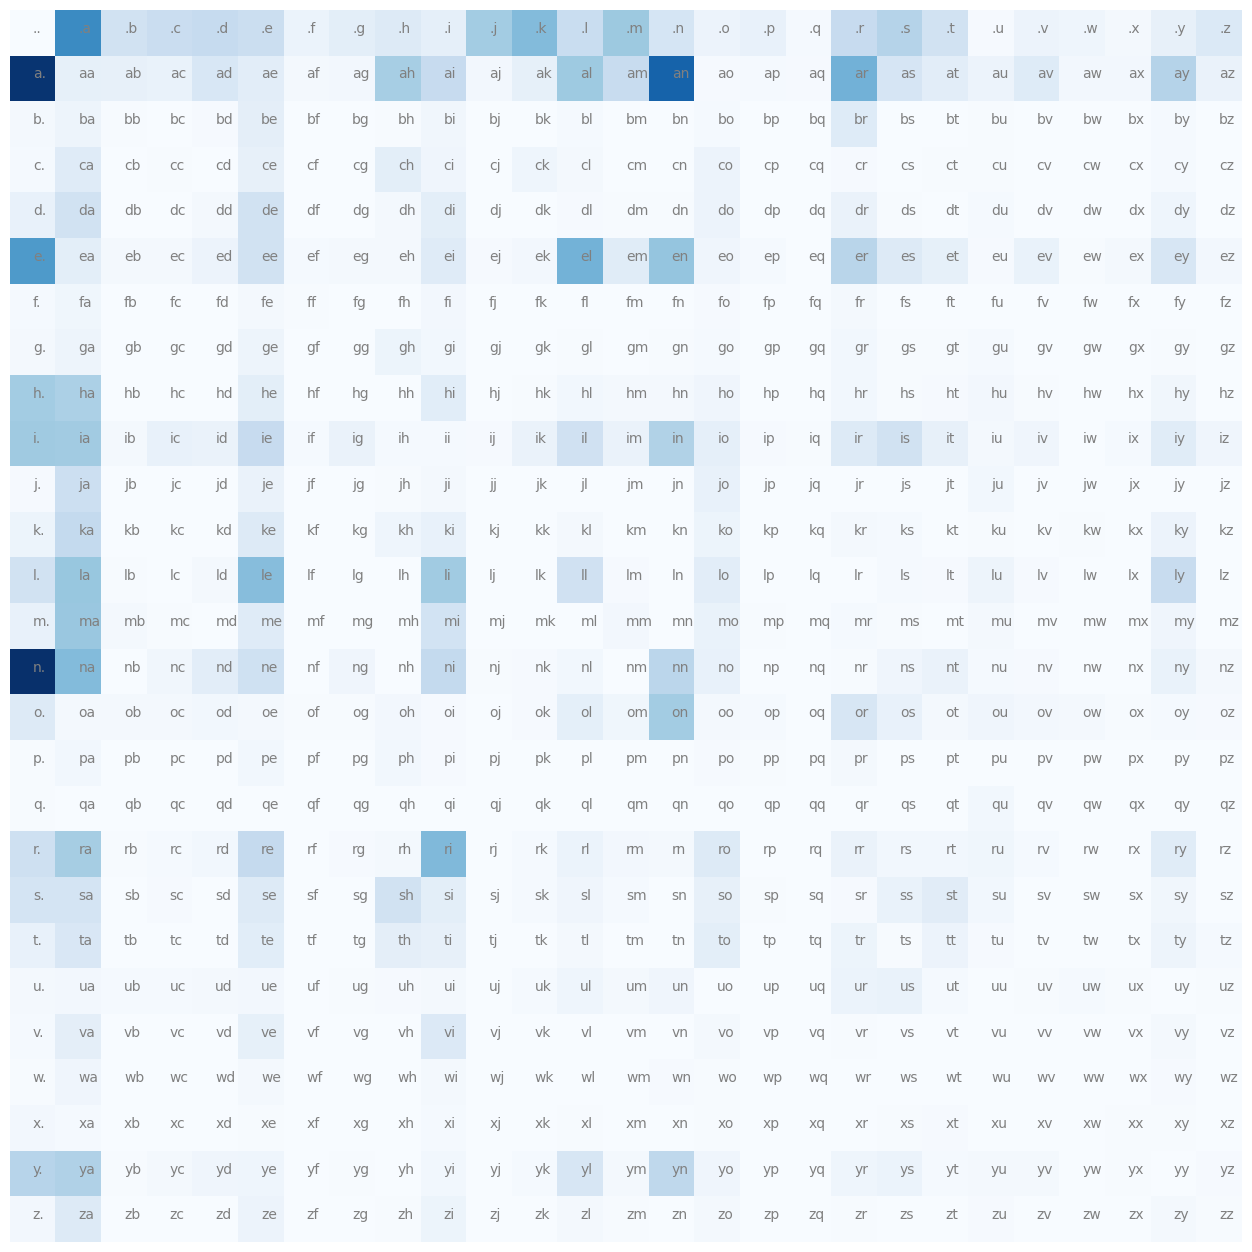

In [13]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N,cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr=itos[i]+itos[j]
        plt.text(j,i,chstr,color='gray')
plt.axis('off')

In [437]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [493]:
p=(N+1).float()
p/=p.sum(1,keepdim=True)

p.shape

torch.Size([27, 27])

In [494]:
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
    ix=0
    out=[]
    
    while True:
        a=p[ix]
        ix=torch.multinomial(a, num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
    print("".join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [497]:
nll=0
log_likelihood=0.0
n=0
for w in words:
    chs=['.']+list(w)+['.']
    for ch1,ch2 in zip (chs[:],chs[1:]):
        ix1,ix2=stoi[ch1],stoi[ch2]
        prob=p[ix1,ix2]
        logprob=torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1},{ch2}:{prob}')
        
print(f'{log_likelihood=}')
nll=-log_likelihood
print(f'{nll/n=}')

log_likelihood=tensor(-559951.5625)
nll/n=tensor(2.4544)


In [790]:
# create the training set of bigrams (x,y)

xs,ys=[],[]

for i in words:
    chs='.'+i+"."
    for ch1,ch2 in zip(chs[:],chs[1:]):
        ix1,ix2=stoi[ch1],stoi[ch2]
        
        xs.append(ix1)
        ys.append(ix2)
xs=torch.tensor(xs)
ys=torch.tensor(ys)

In [796]:
xs.shape

torch.Size([228146])

In [519]:
import torch.nn.functional as F 
xenc =F.one_hot(xs,num_classes=27).float()

In [520]:
xenc.dtype

torch.float32

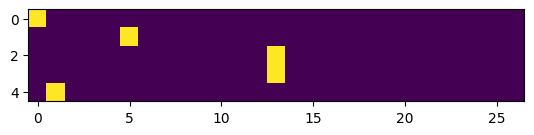

In [521]:
plt.imshow(xenc)

In [522]:
xenc.dtype

torch.float32

In [797]:
g=torch.Generator().manual_seed(2147483647)
w=torch.randn((27,27),generator=g,requires_grad=True); 

In [1015]:
for i in range(100):
    xenc=F.one_hot(xs,num_classes=27).float()
    logits=xenc@w
    counts=logits.exp()
    probs=counts/counts.sum(1,keepdim=True)
    loss=-probs[torch.arange(len(ys)),ys].log().mean()
    w.grad=None
    loss.backward()
    w.data+=-50*w.grad
    print(loss)


tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<NegBackward0>)
tensor(2.4550, grad_fn=<N

In [826]:
probs.shape

torch.Size([228146, 27])

In [827]:
xs

tensor([ 0,  5, 13,  ..., 25, 26, 24])

In [828]:
ys

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [829]:
w.grad.shape

torch.Size([27, 27])

In [830]:
loss=-probs[torch.arange(len(ys)),ys].log().mean()
loss

tensor(3.2852, grad_fn=<NegBackward0>)

In [1002]:
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
    ix=0
    out=[]
    
    
    while True:
        # a=p[ix]
        xenc=F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits=xenc@w
        counts=logits.exp()
        probs=counts/counts.sum(1,keepdim=True)
        a=probs
        ix=torch.multinomial(a, num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
    print("".join(out))
    

junide.
janasah.
prelay.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.


In [884]:
ln=len(ys)

In [873]:
xs,ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [903]:
for i in range(100):
    xenc=F.one_hot(xs,num_classes=27).float()
    logits=xenc@w
    counts=logits.exp()
    probs=counts/counts.sum(1,keepdim=True)
    loss=-probs[torch.arange(ln),ys].log().mean()
    w.grad=None
    loss.backward()
    w.data+=-10*w.grad
    print(loss)


tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4569, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<NegBackward0>)
tensor(2.4568, grad_fn=<N

In [1019]:
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
    ix=0
    out=[]
    while True:
        xenc=F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits=xenc@w 
        counts=logits.exp()
        probs=counts/counts.sum(1,keepdim=True)
        ix=torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))
        
    

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [1023]:
logits.shape

torch.Size([1, 27])

In [1027]:
c=w[ix].exp()
p=c/c.sum()

tensor(1., grad_fn=<SumBackward0>)

In [1032]:
g=torch.Generator().manual_seed(2147483647)
for i in range(10):
    ix=0
    out=[]
    while True:
        xenc=F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits=w[ix]
        counts=logits.exp()
        probs=counts/counts.sum()
        ix=torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))
        
    

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [1037]:
w.exp()

tensor([[5.7526e-03, 9.2294e+00, 2.7331e+00, 3.2270e+00, 3.5368e+00, 3.2040e+00,
         8.7251e-01, 1.3999e+00, 1.8290e+00, 1.2367e+00, 5.0688e+00, 6.2010e+00,
         3.2898e+00, 5.3115e+00, 2.3982e+00, 8.2438e-01, 1.0776e+00, 1.9232e-01,
         3.4300e+00, 4.3007e+00, 2.7373e+00, 1.6302e-01, 7.8670e-01, 6.4230e-01,
         2.8022e-01, 1.1195e+00, 1.9441e+00],
        [9.4209e+00, 7.8886e-01, 7.6757e-01, 6.6684e-01, 1.4784e+00, 9.8181e-01,
         1.9012e-01, 2.3836e-01, 3.3087e+00, 2.3410e+00, 2.4829e-01, 8.0588e-01,
         3.5867e+00, 2.3183e+00, 7.7155e+00, 8.9385e-02, 1.1634e-01, 8.5129e-02,
         4.6310e+00, 1.5862e+00, 9.7472e-01, 5.4057e-01, 1.1833e+00, 2.2843e-01,
         2.5822e-01, 2.9086e+00, 6.1718e-01],
        [9.0506e+00, 2.5685e+01, 2.9345e+00, 1.7219e-01, 5.1104e+00, 5.2522e+01,
         1.3630e-01, 1.2996e-01, 3.1768e+00, 1.7328e+01, 1.7710e-01, 1.1272e-01,
         8.1663e+00, 1.4997e-01, 2.5849e-01, 8.3271e+00, 1.4264e-01, 1.4878e-01,
         6.7548e+